# ASP 3231 Project: NGC 3293
## Flat Image Combine - Cedric Liang

Here I will be combining the flat images in order to produce a median combined flat image.

In [147]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gc
gc.enable()


In [148]:
# set root directory of repo
import os
root_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)


In [149]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#open my flat files and assign them to their band
flat_files = {"V": ccdproc.ImageFileCollection(f"{root_path}/data/", glob_include='Flat_V*'),
              "B": ccdproc.ImageFileCollection(f"{root_path}/data/", glob_include='Flat_B*'),
              "R": ccdproc.ImageFileCollection(f"{root_path}/data/", glob_include='Flat_R*')}

flats = {
    band: [CCDData.read(f"{root_path}/data/{fn}", unit="adu")
           for fn in image_files.files]
    for band, image_files
    in flat_files.items()}



In [150]:
#function to return a dict of flat stats, given an image
def image_stats(image):
    return {
        'Min': np.min(image),
        'Max': np.max(image),
        'Mean': np.mean(image),
        'Median': np.median(image),
        'Stdev': np.std(image)
    }



In [151]:
print("V stats: ", image_stats(flats["V"][0]))
print("\nB stats: ", image_stats(flats["B"][0]))
print("\nR stats: ", image_stats(flats["R"][0]))


V stats:  {'Min': 17068, 'Max': 24721, 'Mean': 22925.218607293875, 'Median': 23087.0, 'Stdev': 706.5667311365166}

B stats:  {'Min': 13175, 'Max': 22332, 'Mean': 20489.062079866442, 'Median': 20625.0, 'Stdev': 694.877838329988}

R stats:  {'Min': 6613, 'Max': 16822, 'Mean': 14905.913510842063, 'Median': 15013.0, 'Stdev': 550.4310847257935}


Here, our stats show that there is clearly a difference in the background for each flat, since the flats for each filter were taken successively. That's because they were taken successively, and as such we'll need to normalise.

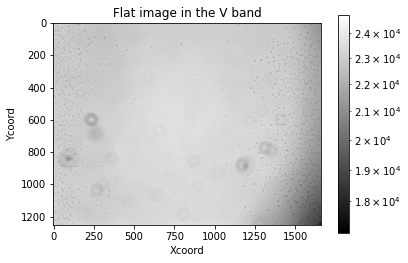

In [152]:
plt.imshow(flats["V"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the V band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 1: Sample dark image in the V band, with a lognorm scaled applied to pixel counts. Note the structural features - vignetting in the corners, large donuts, as well as smaller specks of dust on the glass.

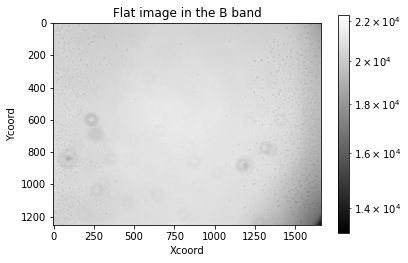

In [153]:
plt.imshow(flats["B"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the B band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 2: Sample dark image in the B band, with a lognorm scaled applied to pixel counts. The structural features are similar, indicating that the dust is on the telescope rather than the filters.

Now we'll need to process flat images using the bias and dark images. Let's first subtract the bias.

In [154]:
# Import the bias
bias_median = CCDData.read(f"{root_path}/src/bias_median.fits")

for key, value in image_stats(bias_median).items():
    print(key, value)

Min 2048.5
Max 2233.0
Mean 2082.5105
Median 2079.0
Stdev 14.54244327545166


These values look about right! Let's subtract them.

In [155]:
flats_min_bias = {band:[ccdproc.subtract_bias(image, bias_median) for image in band_flats_array] for band, band_flats_array in flats.items()}

In [156]:
for key, value in image_stats(flats_min_bias["V"][0]).items():
    print(key, value)

#Note that ou

Min 14926.0
Max 22641.0
Mean 20842.707859847575
Median 21006.5
Stdev 713.6295616987921


Note that our mean and medians have dropped by about 2000. This looks good! Now let's subtract our darks.

In [157]:
dark_median = CCDData.read(f"{root_path}/src/dark_median.fits")

for key, value in image_stats(dark_median).items():
    print(key, value)

Min 66.5
Max 63459.5
Mean 272.417
Median 234.0
Stdev 673.67822265625


In [158]:
flats_min_dark = {band:
                    [ccdproc.subtract_dark(image, dark_median, 
                                                    exposure_time = 'EXPTIME', 
                                                    exposure_unit=u.second, 
                                                    scale=True) 
                        for image in image_array] 
                    for band, image_array in flats_min_bias.items()}

In [159]:
for key, value in image_stats(flats_min_dark["V"][0]).items():
    print(key, value)

Min 14925.942499998957
Max 22640.93388888985
Mean 20842.632188451687
Median 21006.439305555075
Stdev 713.6310561699098


Here, our darks have been subtracted. They haven't affected the pixel counts too much because their counts are being scaled down from the hourlong exposure duration, but the values look right.

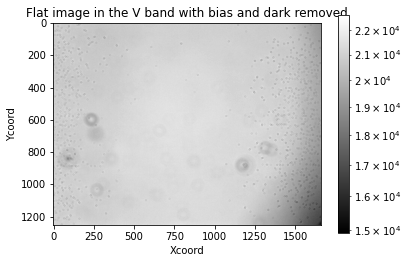

In [160]:
plt.imshow(flats_min_dark["V"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the V band with bias and dark removed")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 3: Our bias and dark removed flat image. Looks pretty similar to the previous images, as they should.

Finally, let's renormalise these flats and combine them.

In [161]:
#dict to hold results
flat_medians = {}

#iterative over subtracted flats
for band, sub_flats in flats_min_dark.items():
    tempimages = sub_flats.copy()
    # produce median for each image
    for idx, image in enumerate(tempimages):
        m = 1.0/ np.ma.median(image)
        #multiply by median for each image
        tempimages[idx] = image.multiply(m * u.adu)
    flat_medians[band] = ccdproc.Combiner(tempimages, dtype=np.float32).median_combine()
        

In [162]:
for key, value in image_stats(flat_medians["V"][0]).items():
    print(key, value)

Min 0.90493596
Max 1.0144674
Mean 0.9897254
Median 0.9946958422660828
Stdev 0.01829480566084385


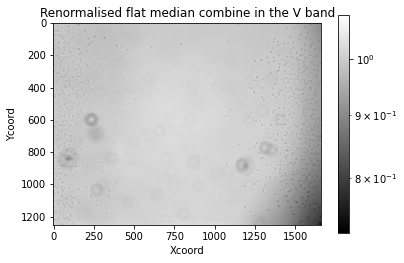

In [163]:
plt.imshow(flat_medians["V"], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Renormalised flat median combine in the V band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 4: We've performed the median combine of the flats, and renormalised. This has generated our structural elements in the image.

We're now happy enough with this to write it to file.

In [164]:
for band, flat_median in flat_medians.items():
    flat_median.meta.update(EXPTIME=1)
    flat_median.meta.update(TELESCOP='C11')
    flat_median.meta.update(OBJECT=f"Flat_{band}_Median")
    flat_median.write(f"Flat_{band}_median.fits", overwrite=True)


In [165]:
del(flats)
del(tempimages)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 9935
